

**Objetivo do estudo:**

> Você é um analista de dados em uma ONG humanitária internacional que arrecadou cerca de R$ 100 bilhões para auxiliar países em necessidade. O CEO da ONG precisa decidir como usar esses fundos de forma estratégica e eficaz, priorizando os países mais necessitados. Sua tarefa é realizar uma análise de classificação dos países com base em fatores socioeconômicos e de saúde, determinando o desenvolvimento geral das nações.

Definir uma lista de paises que devem receber o auxilio e os valores que cada um irá receber, com base em fatores socioeconômicos



Link do Dataset:
https://github.com/GabrielPLeite/DATASETS/blob/main/country_data.csv

Dicionário:

* country: Nome do país.
* child_mort: "Número de óbitos de menores de um ano de idade, por mil nascidos vivos"
* exports: Percentual do PIB que vem das exportações.
* health: Percentual do PIB gasto em saúde.
* imports: Percentual do PIB que vem das importações.
* income: Renda per capita.
* inflation: Taxa de inflação anual.
* life_expec: Expectativa de vida.
* total_fer: Taxa de fertilidade total, medida pelo número médio de filhos por mulher.
* gdpp: Produto Interno Bruto (PIB) per capita.

In [621]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import cluster, datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(0)

In [622]:
df = pd.read_csv('https://raw.githubusercontent.com/GabrielPLeite/DATASETS/main/country_data.csv')

In [623]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


**Linha de raciocínio**

A principio, os paises selecionados para receber a ajuda, devem ter as seguintes caracteristicas:
* baixa expectativa de vida
* alta taxa de mortalidade infantil
* baixo PIB

Essas caracteristicas podem nos mostrar quais estão em maior fragilidade e em uma situação mais urgente

# Tratamento dos dados

In [624]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [625]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [626]:
len(df['country'].unique())

167

De maneira geral, o dataset não apresenta valores nulos, os valore minimos e máximos de cada coluna parecem coerentes e não existem valores de paises duplicados. Iniciaremos a análise e se encontrarmos algo errado trataremos por lá

# Análise

## Expectativa de Vida

Vamos iniciar as análises observando como está a distribuição da expectativa de vida

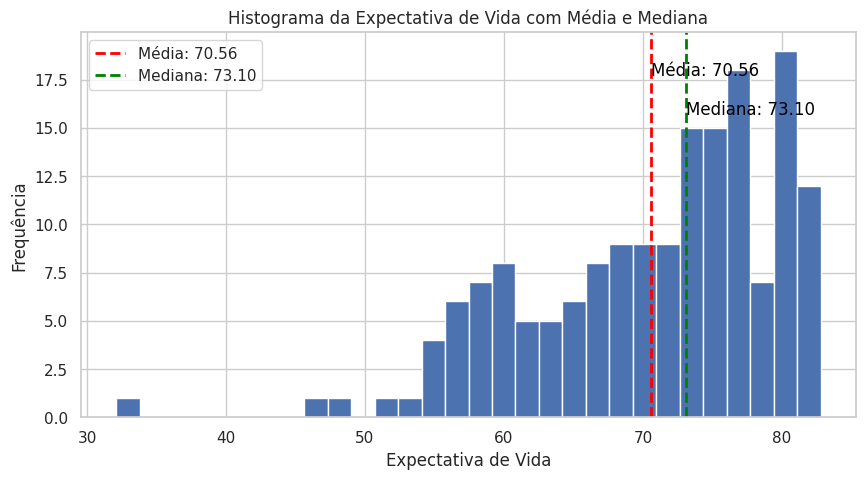

In [627]:
media_expec = df['life_expec'].mean()
mediana_expec = df['life_expec'].median()

plt.figure(figsize=(10, 5))
plt.hist(df['life_expec'], bins=30)

plt.axvline(media_expec, color='red', linestyle='dashed', linewidth=2, label=f'Média: {media_expec:.2f}')
plt.axvline(mediana_expec, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {mediana_expec:.2f}')

plt.text(media_expec, plt.ylim()[1] * 0.9, f'Média: {media_expec:.2f}', color='black', ha='left', va='center')
plt.text(mediana_expec, plt.ylim()[1] * 0.8, f'Mediana: {mediana_expec:.2f}', color='black', ha='left', va='center')

plt.title('Histograma da Expectativa de Vida com Média e Mediana')
plt.xlabel('Expectativa de Vida')
plt.ylabel('Frequência')
plt.legend()

plt.show()

Através da distribuição, podemos ver que a média entre os paises é algo próximo de 70 anos, naturalmente existem paises que estão abaixo da média, mas alguns em especial, estão mais de 20 anos afastados, vamos observar quem são esses

In [628]:
baixa_espec = df['life_expec'] <= 60
df_baixa_espec = df[baixa_espec]
df_baixa_espec.sort_values('life_expec')

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
66,Haiti,208.0,15.30,6.91,64.7,1500,5.45,32.1,3.33,662
87,Lesotho,99.7,39.40,11.10,101.0,2380,4.15,46.5,3.30,1170
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446
166,Zambia,83.1,37.00,5.89,30.9,3280,14.00,52.0,5.40,1460
94,Malawi,90.5,22.80,6.59,34.9,1030,12.10,53.1,5.31,459
137,South Africa,53.7,28.60,8.94,27.4,12000,6.35,54.3,2.59,7280
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419
132,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399
64,Guinea-Bissau,114.0,14.90,8.50,35.2,1390,2.97,55.6,5.05,547
0,Afghanistan,90.2,10.00,7.58,44.9,1610,9.44,56.2,5.82,553


In [629]:
len(df_baixa_espec)

24

Aqui temos uma lista com 24 paises que tem uma baixa expectativa de vida, e por isso merecem uma atenção especial, veremos os outros indicadores.

*Obs: De acordo com o google (2024), a expectativa de vida do haiti está entre 50 a 60 anos, o que continua sendo baixa mas difere da informação do dataset. Como não é apresentado o ano das informações, vamos toma-las como verdade.*

## Mortalidade infantil

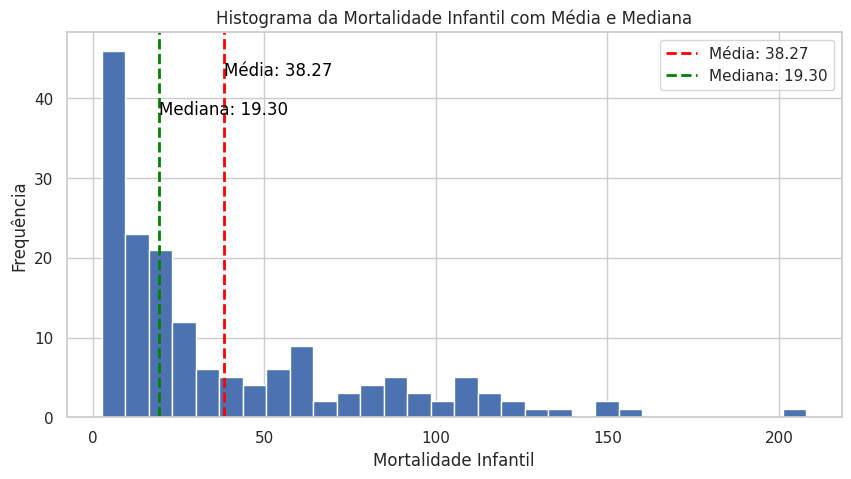

In [630]:
media_cm = df['child_mort'].mean()
mediana_cm = df['child_mort'].median()

plt.figure(figsize=(10, 5))
plt.hist(df['child_mort'], bins=30)

plt.axvline(media_cm, color='red', linestyle='dashed', linewidth=2, label=f'Média: {media_cm:.2f}')
plt.axvline(mediana_cm, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {mediana_cm:.2f}')

plt.text(media_cm, plt.ylim()[1] * 0.9, f'Média: {media_cm:.2f}', color='black', ha='left', va='center')
plt.text(mediana_cm, plt.ylim()[1] * 0.8, f'Mediana: {mediana_cm:.2f}', color='black', ha='left', va='center')

plt.title('Histograma da Mortalidade Infantil com Média e Mediana')
plt.xlabel('Mortalidade Infantil')
plt.ylabel('Frequência')
plt.legend()

plt.show()

Os valores apresentados são a cada 1000 crianças, ou seja, a média de mortalidade infantil destes paises é de aproximadamente 38 crianças a cada 1000, e podemos ver tambem que a mediana é praticamente a metade, isso indica que existem valores muito altos que puxaram a média para cima.

Observando o gráfico é possivel ver os valores muito altos, alguns chegando até proximo de 200, isso quer dizer que praticamente 1 a cada 5 crianças morrem antes completar 1 ano neste pais.

Faremos a identificação dos paises que estão acima de 60

In [631]:
alta_mort_infantil = df['child_mort'] >= 60
df_alta_mort_infantil = df[alta_mort_infantil]
df_alta_mort_infantil.sort_values('child_mort', ascending=False)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
66,Haiti,208.0,15.300,6.91,64.7000,1500,5.450,32.1,3.33,662
132,Sierra Leone,160.0,16.800,13.10,34.5000,1220,17.200,55.0,5.20,399
32,Chad,150.0,36.800,4.53,43.5000,1930,6.390,56.5,6.59,897
31,Central African Republic,149.0,11.800,3.98,26.5000,888,2.010,47.5,5.21,446
97,Mali,137.0,22.800,4.98,35.1000,1870,4.370,59.5,6.55,708
113,Nigeria,130.0,25.300,5.07,17.4000,5150,104.000,60.5,5.84,2330
112,Niger,123.0,22.200,5.16,49.1000,814,2.550,58.8,7.49,348
3,Angola,119.0,62.300,2.85,42.9000,5900,22.400,60.1,6.16,3530
25,Burkina Faso,116.0,19.200,6.74,29.6000,1430,6.810,57.9,5.87,575
37,"Congo, Dem. Rep.",116.0,41.100,7.91,49.6000,609,20.800,57.5,6.54,334


In [632]:
len(df_alta_mort_infantil)

43

Nesta lista temos 43 paises com os indices em valores muito ruins, vamos mante-los em análise para nossas considerações finais.




## PIB per Capta

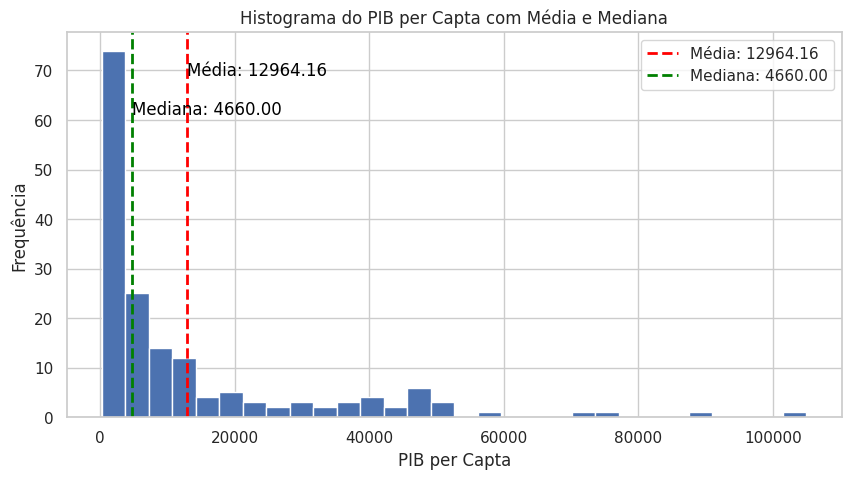

In [633]:
media_PIBc = df['gdpp'].mean()
mediana_PIBc = df['gdpp'].median()

plt.figure(figsize=(10, 5))
plt.hist(df['gdpp'], bins=30)

plt.axvline(media_PIBc, color='red', linestyle='dashed', linewidth=2, label=f'Média: {media_PIBc:.2f}')
plt.axvline(mediana_PIBc, color='green', linestyle='dashed', linewidth=2, label=f'Mediana: {mediana_PIBc:.2f}')

plt.text(media_PIBc, plt.ylim()[1] * 0.9, f'Média: {media_PIBc:.2f}', color='black', ha='left', va='center')
plt.text(mediana_PIBc, plt.ylim()[1] * 0.8, f'Mediana: {mediana_PIBc:.2f}', color='black', ha='left', va='center')

plt.title('Histograma do PIB per Capta com Média e Mediana')
plt.xlabel('PIB per Capta')
plt.ylabel('Frequência')
plt.legend()

plt.show()

Neste gráfico podemos ver uma grande diferença entre a média e a mediana, mostrando novamente a presença de valores muito altos que distorcem a média.

Por mais que esses valores sejam muito altos e pudessem ser considerados outliers, são valores reais, e por isso iremos mantê-los

In [634]:
baixo_PIBc = df['gdpp'] <= 4660/2
df_baixo_PIBc = df[baixo_PIBc]
df_baixo_PIBc.sort_values('gdpp', ascending=True)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
26,Burundi,93.6,8.920,11.60,39.2000,764,12.300,57.7,6.26,231
88,Liberia,89.3,19.100,11.80,92.6000,700,5.470,60.8,5.02,327
37,"Congo, Dem. Rep.",116.0,41.100,7.91,49.6000,609,20.800,57.5,6.54,334
112,Niger,123.0,22.200,5.16,49.1000,814,2.550,58.8,7.49,348
132,Sierra Leone,160.0,16.800,13.10,34.5000,1220,17.200,55.0,5.20,399
93,Madagascar,62.2,25.000,3.77,43.0000,1390,8.790,60.8,4.60,413
106,Mozambique,101.0,31.500,5.21,46.2000,918,7.640,54.5,5.56,419
31,Central African Republic,149.0,11.800,3.98,26.5000,888,2.010,47.5,5.21,446
94,Malawi,90.5,22.800,6.59,34.9000,1030,12.100,53.1,5.31,459
50,Eritrea,55.2,4.790,2.66,23.3000,1420,11.600,61.7,4.61,482


In [635]:
len(df_baixo_PIBc)

52

Essa lista contem os paises que estão com o PIB per Capta menor ou igual a metade da mediana deste métrica, por isso, entendemos que também é um fator a ser levado em consideração.

# Correlações

Vamos fazer algumas verificações para entender a correlação do PIB per Capta com os demais indicadores socioeconômicos que observamos

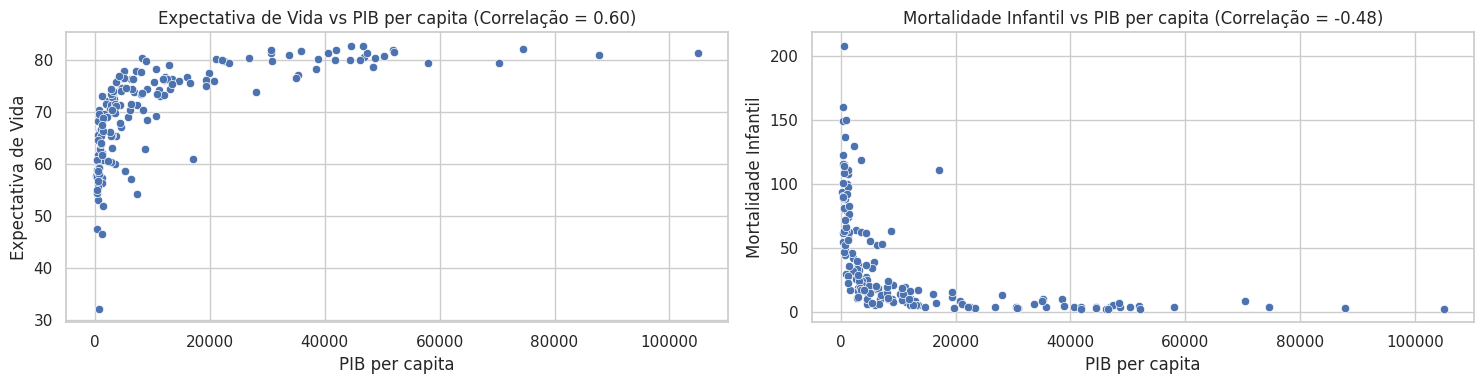

In [636]:
corr_life_gdpp = df['life_expec'].corr(df['gdpp'])
corr_child_gdpp = df['child_mort'].corr(df['gdpp'])

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.scatterplot(x=df['gdpp'], y=df['life_expec'], ax=axes[0])
axes[0].set_title(f'Expectativa de Vida vs PIB per capita (Correlação = {corr_life_gdpp:.2f})')
axes[0].set_xlabel('PIB per capita')
axes[0].set_ylabel('Expectativa de Vida')

sns.scatterplot(x=df['gdpp'], y=df['child_mort'], ax=axes[1])
axes[1].set_title(f'Mortalidade Infantil vs PIB per capita (Correlação = {corr_child_gdpp:.2f})')
axes[1].set_xlabel('PIB per capita')
axes[1].set_ylabel('Mortalidade Infantil')


plt.tight_layout()

plt.show()

Nos gráficos acima podemos tirar as seguintes conclusões:

1.   A expectativa de vida e o PIB per capta tem uma correlação positiva (0,60), ou seja, quanto maior o PIB ou riqueza do pais, maior a expectativa de vida
2.   A mortalidade infantil tem uma correlação negativa (-0,48) com o PIB, o que indica que, quanto maior for o PIB, menor tende a ser mortalidade infantil



# Agrupamentos

In [637]:
# Definição das caracteristicas a serem analisadas
features = ['life_expec', 'child_mort']

In [638]:
# Padronização das caracteristicas
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [639]:
# Geração das métricas de avaliação dos cluster para definir a melhor quantidade
se = []
sil_scores = []
calinski_score = []
davies_score = []
index = range(2, 7)
for i in index:
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(df[features])
    se.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(df[features], labels))
    calinski_score.append(calinski_harabasz_score(df[features], labels))
    davies_score.append(davies_bouldin_score(df[features], labels))

    print('With in sum of squared error (WCSS) at K =', i, ':', kmeans.inertia_)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(df[features], labels))
    print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(df[features], labels))
    print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(df[features], labels))
    print("---------------------------------------------------------------")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

With in sum of squared error (WCSS) at K = 2 : 100.68630311399848
Silhouette Coefficient: 0.644
Calinski-Harabasz Index: 382.344
Davies-Bouldin Index: 0.535
---------------------------------------------------------------
With in sum of squared error (WCSS) at K = 3 : 61.17638490892496
Silhouette Coefficient: 0.559
Calinski-Harabasz Index: 365.689
Davies-Bouldin Index: 0.671
---------------------------------------------------------------
With in sum of squared error (WCSS) at K = 4 : 46.52874912591975
Silhouette Coefficient: 0.473
Calinski-Harabasz Index: 335.691
Davies-Bouldin Index: 0.781
---------------------------------------------------------------
With in sum of squared error (WCSS) at K = 5 : 34.02450672420094
Silhouette Coefficient: 0.446
Calinski-Harabasz Index: 357.066
Davies-Bouldin Index: 0.616
---------------------------------------------------------------
With in sum of squared error (WCSS) at K = 6 : 25.8534069158173
Silhouette Coefficient: 0.461
Calinski-Harabasz Index: 

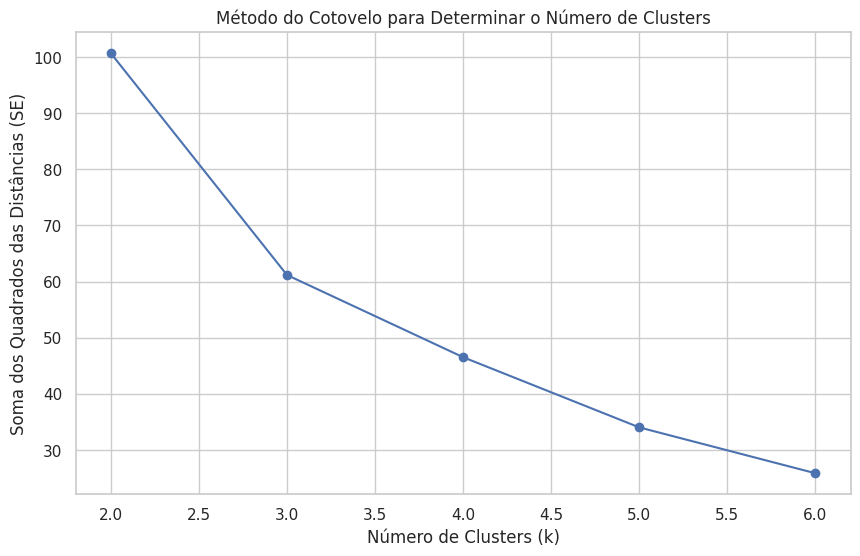

In [655]:
plt.figure(figsize=(10, 6))
plt.plot(index, se, marker='o')
plt.title('Método do Cotovelo para Determinar o Número de Clusters')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Soma dos Quadrados das Distâncias (SE)')
plt.grid(True)
plt.show()

Observando as métricas de qualidade e o gráfico do cotovelo, o valor escolhido será 3

In [640]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[features])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


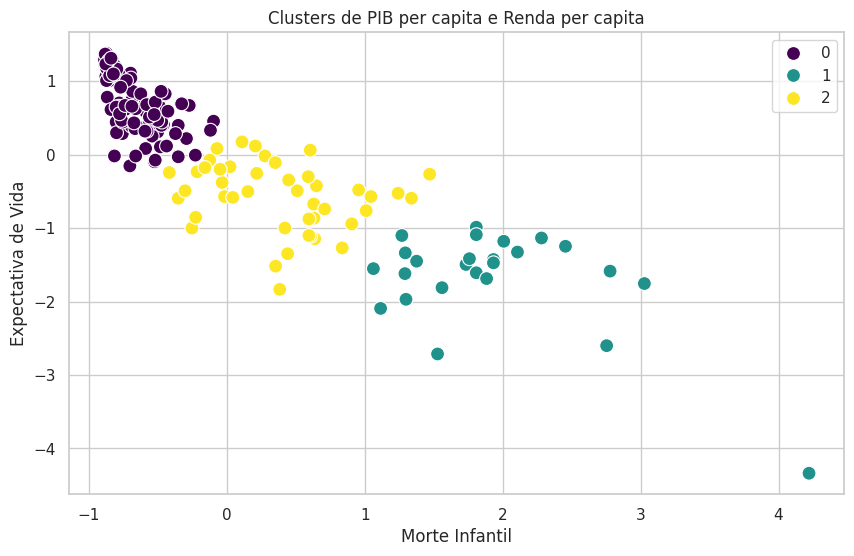

In [641]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='child_mort', y='life_expec', hue='Cluster', data=df, palette='viridis', s=100)

plt.title('Clusters de PIB per capita e Renda per capita')
plt.xlabel('Morte Infantil')
plt.ylabel('Expectativa de Vida')
plt.legend()
plt.show()

Avaliando os clusters:

1. Cluster 0 - Seria o cluster com os paises mais próximos de uma melhor realidade, onde a expectativa de vida é alta e a mortalidade infantial é baixa

2. Cluster 2 - Esse cluster parece ser o intermediario, onde os valores de expectativa de vida são um pouco mais baixos e a mortalidade infantil é um pouco mais alta

3. Cluster 1 - Esse cluster contem os paises com as maiores dificuldades, onde temos as menores expectativas de vida e as maiores mortalidades infantis, sendo esse o nosso alvo para o auxílio

In [642]:
df_cluster_1 = df[df['Cluster'] == 1]
len(df_cluster_1)

25

# Definição dos valores

Para a definição dos valores que deverão ser alocados em cada pais, consideraremos algumas métricas. A escolha dos pesos é algo muito sensivel, mas considerando alguns fatores, foi decidido que ficassem desta maneira:

* Mortalidade Infantil (child_mort): 40%
* Expectativa de Vida (life_expec): 30%
* PIB per Capita (gdpp): 20%
* Salários per Capita (income): 10%

In [643]:
# Padronizando o restante das colunas que serão usadas
pad_ftrs = ['gdpp', 'income']

scaler = StandardScaler()
df[pad_ftrs] = scaler.fit_transform(df[pad_ftrs])

In [644]:
# Invertendo as colunas para que o maior numero seja o mais frágil
df['income'] = -df['income']
df['gdpp'] = -df['gdpp']
df['life_expec'] = -df['life_expec']

In [645]:
# Normalizando as colunas [0 a 1]
norm_ftrs = ['child_mort', 'life_expec', 'gdpp', 'income']

scaler_minmax = MinMaxScaler()
df[norm_ftrs] = scaler_minmax.fit_transform(df[norm_ftrs])

In [646]:
# Verificando se os valores estão entre 0 e 1
colunas_observadas = ['country','child_mort', 'life_expec', 'gdpp', 'income','Cluster']
df_col_obs = df[colunas_observadas]
df_col_obs.describe()

,child_mort,life_expec,gdpp,income,Cluster
count,167.000000,167.000000,167.000000,167.000000,167.000000
mean,0.173661,0.241505,0.878464,0.867067,0.676647
std,0.196343,0.175408,0.174944,0.154980,0.866161
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.027507,0.118343,0.868100,0.821603,0.000000
50%,0.081305,0.191321,0.957726,0.924826,0.000000
75%,0.289679,0.345168,0.989510,0.977924,2.000000
max,1.000000,1.000000,1.000000,1.000000,2.000000


In [647]:
# Verificando se um dos paises mais criticos está com os indices altos
df_col_obs[df_col_obs['country']=='Haiti']

,country,child_mort,life_expec,gdpp,income,Cluster
66,Haiti,1.0,1.0,0.995886,0.992837,1


In [648]:
# Criação da coluna de fragilidade com a atribuição dos pesos
df_col_obs['fragility_index'] = (
    df_col_obs['child_mort'] * 0.4 +
    df_col_obs['life_expec'] * 0.3 +
    df_col_obs['gdpp'] * 0.2 +
    df_col_obs['income'] * 0.1
)

<ipython-input-648-d3f2f82329aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_col_obs['fragility_index'] = (


In [649]:
# Verificação do dataset filtrando pelo indice de fragilidade de maneira ascendente
df_col_obs.sort_values('fragility_index', ascending=True)

,country,child_mort,life_expec,gdpp,income,Cluster,fragility_index
91,Luxembourg,0.000974,0.029586,0.000000,0.267704,0,0.036036
114,Norway,0.002921,0.035503,0.164171,0.504056,0,0.095059
123,Qatar,0.031159,0.065089,0.331205,0.000000,0,0.098231
145,Switzerland,0.009250,0.011834,0.290162,0.558722,0,0.121155
133,Singapore,0.000974,0.001972,0.557417,0.425272,0,0.154992
...,...,...,...,...,...,...,...
87,Lesotho,0.472736,0.715976,0.991037,0.985763,1,0.700671
32,Chad,0.717624,0.518738,0.993643,0.989380,1,0.740338
132,Sierra Leone,0.766310,0.548323,0.998396,0.995088,1,0.770209
31,Central African Republic,0.712756,0.696252,0.997948,0.997757,1,0.793343


In [650]:
# Verificando os valores minimos de cada cluster
min_cluster = df_col_obs.groupby('Cluster')['fragility_index'].max().reset_index()
min_cluster

,Cluster,fragility_index
0,0,0.412428
1,1,0.998461
2,2,0.573349


Após a aplicação da padronização, normalização e criação do indicador de fragilidade, fizemos uma verificação para saber qual o maior valor desse indice para cada um dos cluster, e o resultado foi bem condizendo com o que haviamos visto anteriormente.


Os paises do Cluester 1 estão em uma situação critica, onde o indice beira 1, enquanto os outros clusters estão mais balanceados.


Dada a quantia limitada de recursos financeiros, o dinheiro será distribuido apenas para os paises que se enquadraram no cluster 1

In [651]:
df_escolhidos = df_col_obs[df_col_obs['Cluster'] == 1]
df_escolhidos.sort_values('fragility_index', ascending=False)

,country,child_mort,life_expec,gdpp,income,Cluster,fragility_index
66,Haiti,1.000000,1.000000,0.995886,0.992837,1,0.998461
31,Central African Republic,0.712756,0.696252,0.997948,0.997757,1,0.793343
132,Sierra Leone,0.766310,0.548323,0.998396,0.995088,1,0.770209
32,Chad,0.717624,0.518738,0.993643,0.989380,1,0.740338
87,Lesotho,0.472736,0.715976,0.991037,0.985763,1,0.700671
97,Mali,0.654333,0.459566,0.995447,0.989863,1,0.697679
64,Guinea-Bissau,0.542356,0.536489,0.996984,0.993721,1,0.676658
112,Niger,0.586173,0.473373,0.998883,0.998352,1,0.676093
113,Nigeria,0.620253,0.439842,0.979965,0.963494,1,0.672396
37,"Congo, Dem. Rep.",0.552093,0.499014,0.999017,1.000000,1,0.670345


O dinheiro dado para os paises será proporcional ao seu indice de fragilidade

In [652]:
valor_arrecadacao = 100000000000
total_fragilidade = df_escolhidos['fragility_index'].sum()

df_escolhidos['Valor (BI)'] = (df_escolhidos['fragility_index']/total_fragilidade)*valor_arrecadacao
df_escolhidos['Valor (BI)'] = (df_escolhidos['Valor (BI)']/1000000000).round(2)

<ipython-input-652-3a14bc103e26>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_escolhidos['Valor (BI)'] = (df_escolhidos['fragility_index']/total_fragilidade)*valor_arrecadacao
<ipython-input-652-3a14bc103e26>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_escolhidos['Valor (BI)'] = (df_escolhidos['Valor (BI)']/1000000000).round(2)


In [653]:
df_escolhidos.sort_values('fragility_index', ascending=False)

,country,child_mort,life_expec,gdpp,income,Cluster,fragility_index,Valor (BI)
66,Haiti,1.000000,1.000000,0.995886,0.992837,1,0.998461,5.91
31,Central African Republic,0.712756,0.696252,0.997948,0.997757,1,0.793343,4.69
132,Sierra Leone,0.766310,0.548323,0.998396,0.995088,1,0.770209,4.56
32,Chad,0.717624,0.518738,0.993643,0.989380,1,0.740338,4.38
87,Lesotho,0.472736,0.715976,0.991037,0.985763,1,0.700671,4.14
97,Mali,0.654333,0.459566,0.995447,0.989863,1,0.697679,4.13
64,Guinea-Bissau,0.542356,0.536489,0.996984,0.993721,1,0.676658,4.00
112,Niger,0.586173,0.473373,0.998883,0.998352,1,0.676093,4.00
113,Nigeria,0.620253,0.439842,0.979965,0.963494,1,0.672396,3.98
37,"Congo, Dem. Rep.",0.552093,0.499014,0.999017,1.000000,1,0.670345,3.97


# Conclusão

Desta maneira foi possivel identificar o grupo dos paises mais frágeis, realizar cálculos para criar um indice de fragilidade para cada um dos paises e alocar a verba arrecadada de maneira proporcional ao indice, garantindo que aqueles que se encontram nas maiores dificuldades tenham um maior auxilio para que possam se estruturar e encontrar um caminho para sair dessa situação.